<div style="
    background-color: #0b2343; 
    color: white; 
    padding: 25px; 
    font-family: Arial, sans-serif;
">
    <h2 style="margin: 0; font-size: 24px; font-weight: normal;">
        Data Analytics & Machine Learning in Finance
    </h2>
    <h1 style="margin: 5px 0 0 0; font-size: 48px; font-weight: bold;">
        K-Nearest Neighbors (K-NN)
    </h1>
    <p style="margin: 8px 0 0 0; font-size: 18px;">
        Pedro Ramón Ventura Gómez
    </p>
    <p style="margin: 2px 0 0 0; font-size: 16px;">
        pventura@march-am.com
    </p>
</div>


# K-Nearest Neighbors (K-NN)

**K-Nearest Neighbors (K-NN)** is a **supervised machine learning algorithm** used for classification tasks.

* **Supervised:** Requires a labeled training dataset (features and target variable) to make predictions.
* **Classification:** Predicts the class of a new sample by looking at the *k* closest samples in the training set and assigning the most frequent class among them.
* **Non-parametric:** Makes no assumptions about the underlying data distribution or a fixed number of parameters. Instead, it stores the entire training set and bases predictions on a **distance (proximity) metric**.
* **Main hyperparameter:** *k* — the number of neighbors used to determine the prediction.

<img src="images/algorithms/knn-intro.png" style="width:25%">

To classify a new sample $x_i$, we identify its *k* nearest neighbors and count how many belong to each class:

$$
P(C_j \mid x_i) = \frac{K_{C_j}}{K}
$$

Where:

* $P(C_j \mid x_i)$ is the estimated probability of class $C_j$ for sample $x_i$
* $K_{C_j}$ is the number of neighbors of class $C_j$ among the *k* nearest

In the example below, the *green* point is:

* **Classified as Red** if $k=3$ (2 red vs. 1 blue)
* **Classified as Blue** if $k=5$ (3 blue vs. 2 red)

<div style="text-align: center;">
    <table border="1" cellpadding="6" cellspacing="0">
        <thead>
            <tr>
                <th colspan=2 style="text-align: center;">K=3</th>
                <th colspan=2 style="text-align: center;">K=5</th>
            </tr>
            <tr>
                <th>Red</th>
                <th>Blue</th>
                <th>Red</th>
                <th>Blue</th>
            </tr>
        </thead>
        <tbody>
            <tr>
                <td>2/3</td>
                <td>1/3</td>
                <td>2/5</td>
                <td>3/5</td>
            </tr>
            <tr>
                <td colspan=2 style="text-align: center;">Red</td>
                <td colspan=2 style="text-align: center;">Blue</td>
            </tr>
        </tbody>
    </table>
</div>


**Finding the nearest neighbors**

The most common similarity measure is the **Euclidean distance**:

$$
d(p,q) = \sqrt{\sum_{i=1}^{n} (p_i - q_i)^2}
$$

Where $p$ and $q$ are two points in an $n$-dimensional space.


**Important considerations**

* **Feature scaling:** Variables with different scales can distort distances — normalization or standardization is usually required.
* **Categorical features:** Need proper encoding (e.g., one-hot) or a suitable distance metric.
* **Choosing $k$:** Small $k$ can lead to overfitting (high variance), while large $k$ can smooth out decision boundaries excessively (high bias).

In practice, most ML problems require **feature preprocessing** before applying the algorithm to ensure that the distance metric reflects meaningful similarities.

# Playing with financial assets

Suppose we want to develop an algorithm that tells us whether to invest in a certain asset with an investment horizon of a month (buy and hold strategy).

Our investment thesis is as follows: We assume that past behavior can predict future behavior, meaning that the closest past vectors to the present will indicate what to expect next month.

We will do the following:
1. Download the asset data (adjusted close px).
2. Transform px to monthly log returns.
3. Create features (X) and target (y):
    - X: 6 months returns vector.
    - y: next month return.
4. Split into train and test datasets.
5. Train a K-NN model.
6. Evaluate trained model.

In [1]:
import pprint
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report


Download data

In [2]:
# Asset ticker.
asset = "TSLA"
# Pay attention to "auto_adjust=True".
px = yf.download(asset, start="2005-12-31", end="2024-12-31", auto_adjust=True)["Close"]

[*********************100%***********************]  1 of 1 completed


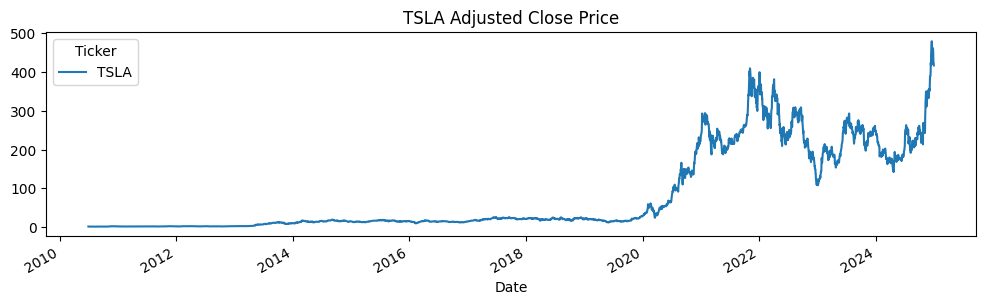

In [3]:
px.plot(figsize=(12, 3), title=f"{asset} Adjusted Close Price")
plt.show()

Compute monthly log returns

In [4]:
# Monthly resample of px (index to Business Month End), take last value.
px_monthly = px.resample("BME").last()
# Compute log returns.
ret = np.log(px_monthly).diff().dropna()

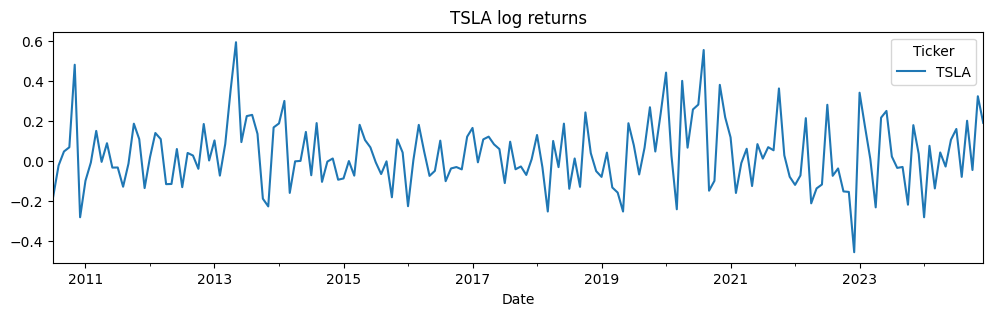

In [5]:
ret.plot(figsize=(12, 3), title=f"{asset} log returns")
plt.show()

Create features (X) and target (y) using a rolling window:
- X: 3 months returns vector.
- y: next month return.

In [6]:
window_size = 6
target_size = 1
X = []  # Features.
y = []  # Target.
for i in range(ret.shape[0] - window_size - target_size):
    X.append(ret.iloc[i : i + window_size].values)
    y.append(ret.iloc[i : i + window_size + target_size].sum().values)

In [7]:
pprint.pprint((len(X), len(y)))  # Dataset length.
pprint.pprint((len(X[0]), len(y[0])))  # Features and target length.

(167, 167)
(6, 1)


[[-0.17821805]
 [-0.02333895]
 [ 0.0466367 ]
 [ 0.06771792]
 [ 0.48098923]
 [-0.28269412]]
[0.01126655]


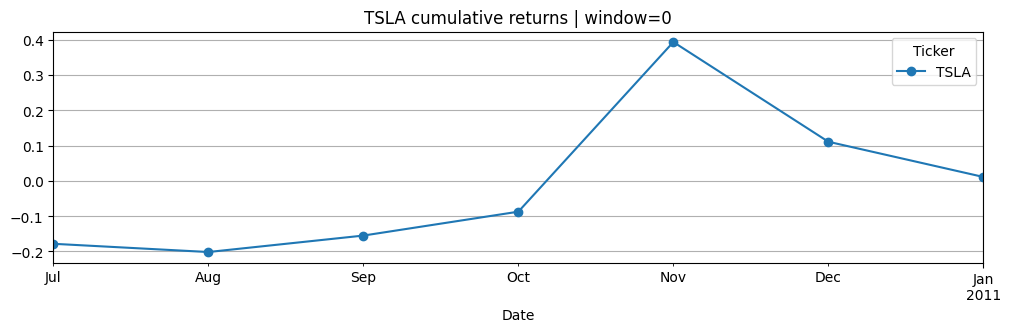

In [8]:
i = 0
print(ret.iloc[i : i + window_size].values)
print(ret.iloc[i : i + window_size + target_size].sum().values)
ret.iloc[i : i + window_size + target_size].cumsum().plot(
    grid=True, figsize=(12, 3), title=f"{asset} cumulative returns | window={i}", marker="o"
)
plt.show()


Split into train and test datasets.

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

X_train = np.array(X_train).reshape(-1, window_size)
X_test = np.array(X_test).reshape(-1, window_size)
y_train = np.array(y_train).reshape(-1) > 0
y_test = np.array(y_test).reshape(-1) > 0

In [10]:
pprint.pprint((len(X_train), len(y_train)))
pprint.pprint((len(X_test), len(y_test)))

(133, 133)
(34, 34)


Train a K-NN model.

In [11]:
K = 3
knn = KNeighborsClassifier(n_neighbors=K)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)


Evaluate trained model.

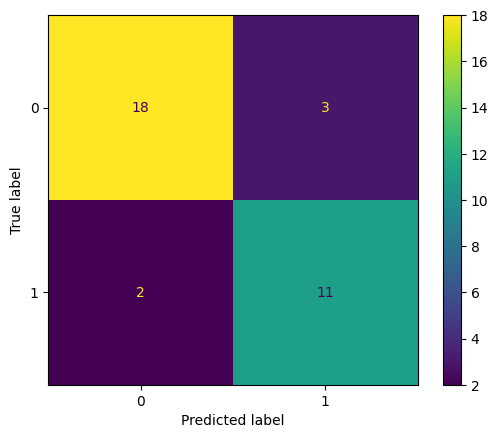

In [12]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()


In [13]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.90      0.86      0.88        21
        True       0.79      0.85      0.81        13

    accuracy                           0.85        34
   macro avg       0.84      0.85      0.85        34
weighted avg       0.86      0.85      0.85        34



Check neighbors

In [14]:
# Closest neighbors to a sample and their distances.
# First tuple element indicates distances.
# Second tuple element indicates indices.
sample_index = 0
knn.kneighbors(X_test[None, sample_index])


(array([[0.23159265, 0.27495254, 0.27929214]]), array([[97, 93, 26]]))

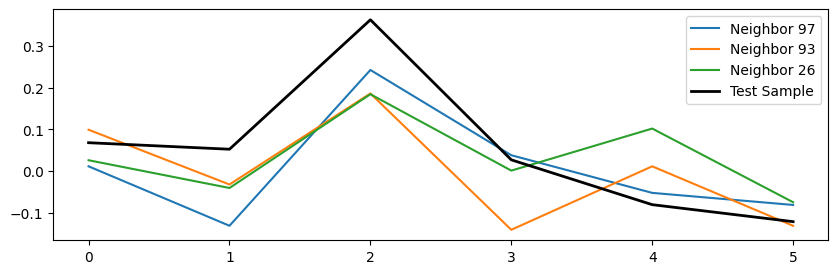

In [15]:
plt.figure(figsize=(10, 3))
for i in knn.kneighbors(X_test[None, sample_index])[1][0]:
    plt.plot(X_train[i], label=f"Neighbor {i}")
plt.plot(X_test[sample_index], label="Test Sample", linewidth=2, color="black")
plt.legend()
plt.show()


**Homework**  
- Use weekly resampling on Wednesdays.  
- Develop the investment algorithm.  
- Present the strategy results and conclusions.  